In [3]:
%%HTML
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>

# Project Name: Place Portrait in Yelper's World
## Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
from folium import IFrame
from folium.features import CustomIcon
import imageio
import json
import os
from bs4 import BeautifulSoup as Soup
import time
import datetime
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:

images_dict = {
           'Auto,Transportation':'data/icon/transportation.png',
      'Entertainment & Catering':'data/icon/catering.png',
                     'Education':'data/icon/education.png',
           'Fitness,Health Care':'data/icon/fitness_health.png',
         'House-inside Services':'data/icon/home_service.png',  
               'Nearby Services':'data/icon/nearby_service.png',
    'Other Professional Service':'data/icon/professional.png',
             'Public Facilities':'data/icon/theatre.png',
                      'Shopping':'data/icon/shopping.png'
}

state_shp_dict = {
    'AZ': 'data/shape/az_500k/cb_2017_04_place_500k.shp',
    'IL': 'data/shape/il_500k/cb_2017_17_place_500k.shp',
    'NC': 'data/shape/nc_500k/cb_2017_37_place_500k.shp',
    'NV': 'data/shape/nv_500k/cb_2017_32_place_500k.shp',
    'OH': 'data/shape/oh_500k/cb_2017_39_place_500k.shp',
    'PA': 'data/shape/pa_500k/cb_2017_42_place_500k.shp' ,  
    'WI': 'data/shape/wi_500k/cb_2017_55_place_500k.shp'
}

icons_dict = {}
for key in images_dict:
    icons_dict[key] = imageio.imread(images_dict[key])

def get_city_coor(lat_lon_s):
    return np.mean(lat_lon_s)

def ecdf(data) :
    n = len(data)
    x = np.sort(data)
    y = np.arange(1,n+1)/n
    return x,y

def add_choropleth(map_obj,geo_data,data,key_col,val_col,geo_key,legend_name):
    map_obj.choropleth(
        geo_data=geo_data,
        data=data,
        columns=[key_col, val_col],
        name = ('{}{}'.format(data[key_col], data[val_col])),
        key_on='feature.properties.{}'.format(geo_key),
        fill_color='YlGn',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=legend_name,
        highlight=True
    )
    return map_obj

def add_place_marker(map_obj,df_coor,df_stats_all,df_stats_group,key_col,marker_num,i_size=10):
    places_list = list(df_stats_all[key_col])
    for index, row in df_coor.iterrows():
        if row[key_col] in places_list:
            #state_br = row['state_br']
            place_name = row[key_col]
            place_business_count = df_stats_all[df_stats_all[key_col]==place_name].business_count.values[0]
            place_avg_star = df_stats_all[df_stats_all[key_col]==place_name].avg_stars.values[0]
            lat = row['latitude']
            lon = row['longitude'] 
            cat_num = len(df_stats_group[df_stats_group[key_col]==place_name].cat_groups)
            html="""
                <h4></h4>
            """           
            soup = Soup(html, 'html.parser')
            soup.h4.string = "Businesses in {}".format(place_name)
                      
            new_tag = soup.new_tag("p")
            new_tag.string = "Total business number: {}, Average Star: {}".format(place_business_count,place_avg_star)
            soup.append(new_tag)
            for i in range(marker_num):
                if i+1 <= cat_num:
                    t_cat = df_stats_group[df_stats_group[key_col]==place_name].cat_groups.values[i]
                    t_count = df_stats_group[df_stats_group[key_col]==place_name].business_count.values[i] 
                    t_star = df_stats_group[df_stats_group[key_col]==place_name].avg_stars.values[i] 
                    new_tag = soup.new_tag("p")
                    new_tag.string = "Top {}: {}, {} Businesses, Average Star: {}".format(i+1,t_cat,t_count,t_star)
                    soup.append(new_tag)
                
            popup = str(soup)
                
            for i in range(marker_num): 
                
                if key_col=='state':
                    k = (-1)**i
                    lat_shift = 0.5*k
                    lon_shift = 0.7*(i-1)
                if key_col == 'city':
                    k = (-1)**i
                    lat_shift = 0.006*k
                    lon_shift = 0.009*(i-1)
                if i+1 <= cat_num:
                    t_cat = df_stats_group[df_stats_group[key_col]==place_name].cat_groups.values[i]
                    icon = icons_dict[t_cat]
                    t_icon = folium.features.CustomIcon(icon,icon_size=(i_size, i_size))  
                    
                    marker = folium.Marker(location=[lat+lat_shift,lon+lon_shift],icon=t_icon,popup=popup)
                    map_obj.add_child(marker)
                
    return map_obj

def add_business_id(map_obj,df,i_size=10):
    
    review_votes = {}
    for index,row in df.iterrows():
        place_name = row['name']
        cat_group = row['cat_groups']
        category = row['categories']
        stars = row['stars']
        review_count = row['review_count']
        review_votes['useful'] = row['useful']
        review_votes['funny'] = row['funny']
        review_votes['cool'] = row['cool']
        lat = row['latitude']
        lon = row['longitude']

        html="""
                <h4>Business Information</h4>
                Business Name: {name}<br>
                Service Description:{category}<br>
                Stars: {stars}<br>
                Review Count: {review_count}<br>
                Votes for reviews ( Useful:{useful_vote}, Funny:{funny_vote}, Cool:{cool_vote} )
            """           
        iframe = folium.IFrame(html=html.format(name=place_name,category=category,stars=stars,review_count=review_count,
                                                useful_vote=review_votes['useful'],funny_vote=review_votes['funny'],
                                                cool_vote=review_votes['cool']),
                                width=460, height=200)
        popup = folium.Popup(iframe, max_width=460)
        
        icon = icons_dict[cat_group]
        t_icon = folium.features.CustomIcon(icon,icon_size=(i_size, i_size))  
                    
        marker = folium.Marker(location=[lat,lon],icon=t_icon,popup=popup)
        map_obj.add_child(marker)
    return map_obj

In [3]:

def usa_geo_data(statistics_total,statistics_group):
    geo_data_dict = {}
    us_states = os.path.join('data','us-states.json')
    
    geo_states = gpd.read_file(us_states)
    geo_states = geo_states.rename(columns={'id':'state','name':'state_name'})
    geo_states = geo_states.to_crs({'init': 'epsg:4326'})

    states_n_b = geo_states[['state','state_name']]
    
    us_states_coor_js = os.path.join('data','us_states_coordinates.json')
    us_states_coor = pd.DataFrame(json.load(open(us_states_coor_js)))
    us_states_coor = us_states_coor.rename(columns={'state':'state_name'})    
    us_states_coor = pd.merge(us_states_coor,states_n_b,on=['state_name'],how='left')
       
    geo_data_dict['coor'] = [43,-100]
    geo_data_dict['zoom'] = 5
    geo_data_dict['i_size'] = 32
    geo_data_dict['icon_num'] = 3
    geo_data_dict['key_col'] = 'state'
    
    geo_data_dict['geo_poly_data'] = geo_states
    geo_data_dict['places_coor'] = us_states_coor
    
    geo_data_dict['statistics_total'] = statistics_total
    geo_data_dict['statistics_group'] = statistics_group
    
    
    return geo_data_dict

def cities_geo_data(state,statistics_total,statistics_group):
    geo_data_dict = {}
    shp_file = state_shp_dict[state]
    geo_cities = gpd.read_file(shp_file)
    
    geo_cities = geo_cities[['STATEFP','GEOID','NAME','geometry']]
    geo_cities = geo_cities.rename(columns={'NAME':'city'})
    geo_cities = geo_cities.to_crs({'init': 'epsg:4326'})
    

    cities_coor = business[business['state']==state].groupby(['state','city'])[['latitude',
                                                                          'longitude']].agg(get_city_coor).reset_index()
    
    geo_data_dict['coor'] = [np.median(cities_coor['latitude']),np.median(cities_coor['longitude'])]
    
    geo_data_dict['zoom'] = 11
    geo_data_dict['i_size'] = 26
    geo_data_dict['icon_num'] = 5-round(len(cities_coor)/30)
    if (geo_data_dict['icon_num']<=2):
        geo_data_dict['icon_num'] = 2
        
    geo_data_dict['key_col'] = 'city'
    
    geo_data_dict['geo_poly_data'] = geo_cities
    geo_data_dict['places_coor'] = cities_coor
    
    geo_data_dict['statistics_total'] = statistics_total[statistics_total['state']==state]
    geo_data_dict['statistics_group'] = statistics_group[statistics_group['state']==state]   
    return geo_data_dict
    
def businesses_geo_data(state,city):
    geo_data_dict = {}
    bl = (business['state']==state) & (business['city']==city)
    businesses_coor = business[bl][['latitude','longitude']]
    
    geo_data_dict['coor'] = [np.median(businesses_coor['latitude']),np.median(businesses_coor['longitude'])]
    geo_data_dict['zoom'] = 16
    geo_data_dict['i_size'] = 26
    geo_data_dict['state'] = state
    geo_data_dict['city'] = city
    return geo_data_dict
    

In [4]:

def map_states_cities(data_dict):
    coor = data_dict['coor']
    zoom = data_dict['zoom']
    key_col = data_dict['key_col']
    geo_poly_data = data_dict['geo_poly_data']
    places_coor = data_dict['places_coor']
    df_statistics_total = data_dict['statistics_total']
    df_statistics_group = data_dict['statistics_group']
    i_size = data_dict['i_size']
    icon_num = data_dict['icon_num']
    m = folium.Map(coor, zoom_start=zoom,control_scale=True)
    m = add_choropleth(m,geo_poly_data,df_statistics_total,key_col,'business_count',key_col,'Businesses Count')
    m = add_place_marker(m,places_coor,df_statistics_total,df_statistics_group,key_col,icon_num,i_size=i_size)
    return m

def map_city_businesses(data_dict):
    coor = data_dict['coor']
    zoom = data_dict['zoom']
    state = data_dict['state']
    city = data_dict['city']
    i_size = data_dict['i_size']

    m = folium.Map(coor, zoom_start=zoom,control_scale=True)
    bl = (business['state']==state) & (business['city']==city)
    df_city = business[bl].sort_values(by=['review_count'],ascending=False)
    if len(df_city) > 200:
        df_city = df_city[0:200]
        
    m=add_business_id(m,df_city,i_size=i_size)   
    return m

def choose_city(City): 
    if City != 'Choose a City': 
        state = City.split(',')[1]
        city = City.split(',')[0]
        data_dict = businesses_geo_data(state,city)  
        return map_city_businesses(data_dict)

def choose_state(State):
    
    if State != 'Choose a State': 
        data_dict = cities_geo_data(State,stats_3,stats_4)
        cities_list = ['Choose a City']
        cities = data_dict['statistics_total']['city']
        for index,item in cities.iteritems():
            cities_list.append(item+','+State)
        
        interact(choose_city,City=cities_list)
        return map_states_cities(data_dict)

def choose_map_type(MapType):
    data_dict = usa_geo_data(stats_1,stats_2)
           
    if MapType == 'USA':
        return map_states_cities(data_dict)

    if MapType == 'State':
        states_list = ['Choose a State']
        states = data_dict['statistics_total']['state']
        for index,item in states.iteritems():
            states_list.append(item)
        interact(choose_state, State=states_list)

def autolabel(rects,ax):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%d' % int(height),
                ha='center', va='bottom')

def annotateBars(row, ax): 
    for p in ax.patches:
        ax.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=12, color='grey' , xytext=(0, 10),
                    textcoords='offset points')  

### Read business data from the cleaned file
Set the data type of the 'postal_code' to the string type.

In [5]:
business = pd.read_csv('data/business_clean.csv',index_col=0)
business['postal_code'] = business['postal_code'].astype('str') 

### Graphical Data Exploration 

We first make a plot of businesses' frequencies within different category group.

In [6]:
business_count1 = business.groupby(['cat_groups'])['business_id'].count().reset_index()
business_count1 = business_count1.rename(columns={'business_id':'business_count'})

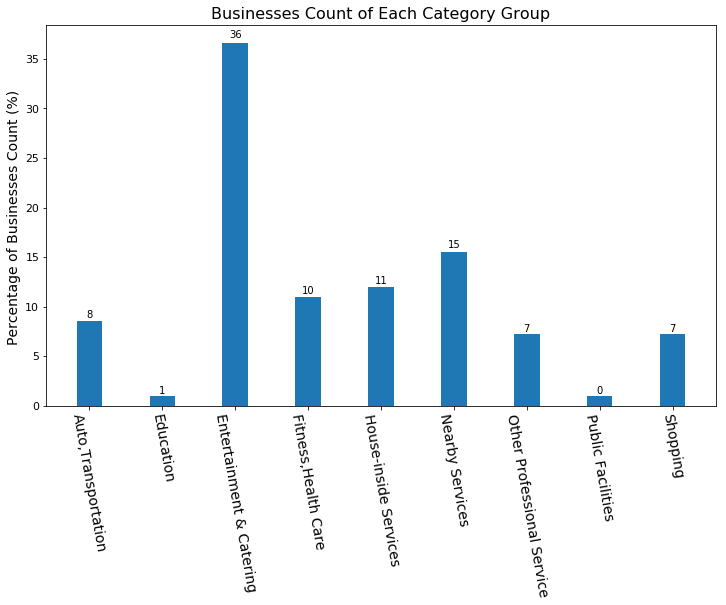

In [7]:
plt.figure(figsize=(12,7))
plt_1 = plt.bar(business_count1.cat_groups,business_count1.business_count*100/business_count1.business_count.sum(),width=0.35)
plt.xticks(rotation=280,size=14)
plt.yticks(size=11)
plt.ylabel("Percentage of Businesses Count (%) ",size=14)
plt.title("Businesses Count of Each Category Group",size=16)
ax = plt.gca()
autolabel(plt_1,ax)
plt.show()

Within this plot, we can find that, in the nine category groups,  **'Entertainment & Catering' has the biggest number of businesses, which is about 36% of total number of all businesses.** The next one is 'Nearby Services' which has 15% businesses. 'House-inside Services' and 'Fitness,Health Care' are 11% and 10%. 

**These four groups are the major business fields of the Yelpers' activities, and they own 72% businesses.**

Next, we can make a plot of businesses' frequencies in different category group and in different state.

In [8]:
business_count2 = business.groupby(['cat_groups','state'])['business_id'].count().reset_index()
business_count2 = business_count2.rename(columns={'business_id':'business_count'})

This time we will use the factorplot of the seaborn.

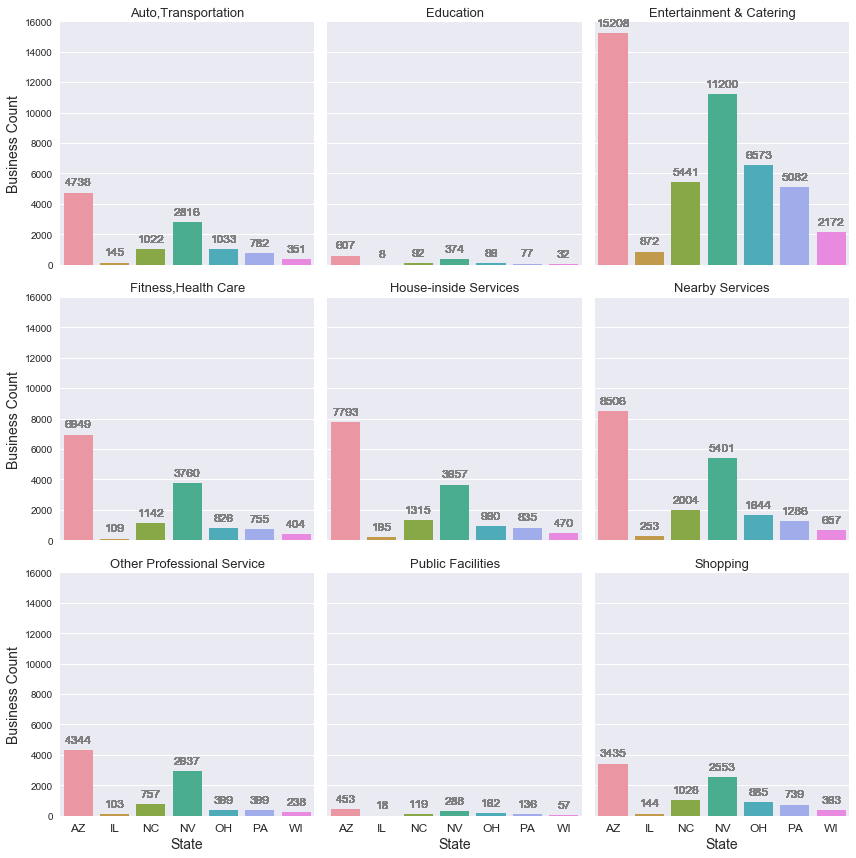

In [9]:
colors = ["magenta","windows blue", "amber", "greyish", "faded green", "dusty purple","chocolate"]
pal = sns.xkcd_palette(colors)
sns.set()
plt.figure(dpi=600)
plt_2 = sns.factorplot(x='state',y='business_count',col='cat_groups',kind='bar',col_wrap=3,data=business_count2)
ax = plt.gca()
(plt_2.set_xlabels("State",size=14)
     .set_ylabels("Business Count",size=14)
     .set_xticklabels(size=12)
    .set_titles("{col_name}",size=13)
    .despine(left=True))
        
for ax in plt_2.axes.flatten():
    business_count2.apply(annotateBars, ax=ax, axis=1)

plt.show()


In the current data set, Arizona and Nevada nearly have half or more of businesses comparing to other five states. This may be the reason that the Yelp company doesn't offer full data for each state. For example, there are no any data of Philadelphia PA. But we still can do statistics for cities offered in this data set.

### Statistics for states and cities
We will make statistics on state-level and city-level. 

For state-level, we will count the number of all businesses for each state; sum 'review_count','review_votes','useful' and 'funny'; and calculate the average stars for each state. We also do same thing for each business category group in each state.

In [10]:
stats_1 = business.groupby('state')[['review_count','review_votes','useful','funny','cool']].agg('sum')
stats_1['business_count'] = business.groupby('state')['business_id'].agg('count')
stats_1['avg_stars'] = round(business.groupby('state')['stars'].agg('mean'),2)
stats_1 = stats_1.reset_index()
stats_1

,state,review_count,review_votes,useful,funny,cool,business_count,avg_stars
0,AZ,1626599,3965302,2298110,778284,888907,52033,3.73
1,IL,36354,83897,54729,15952,13216,1847,3.49
2,NC,307241,594562,357185,113261,124116,12920,3.58
3,NV,1823791,4997199,2627722,1090966,1278511,32986,3.72
4,OH,243502,539333,312736,111577,115020,12568,3.55
5,PA,229725,552262,311440,100414,140408,10091,3.61
6,WI,109694,243452,148733,40998,53721,4744,3.64


In [11]:
stats_2 = business.groupby(['state','cat_groups'])[['review_count','review_votes','useful','funny','cool']].agg('sum')
stats_2['business_count'] = business.groupby(['state','cat_groups'])['business_id'].agg('count')
stats_2['avg_stars'] = round(business.groupby(['state','cat_groups'])['stars'].agg('mean'),2)
stats_2 = stats_2.reset_index()
stats_2 = stats_2.sort_values(['state','business_count'],ascending=[True,False])
stats_2.head()

,state,cat_groups,review_count,review_votes,useful,funny,cool,business_count,avg_stars
2,AZ,Entertainment & Catering,1053252,2435910,1266770,530276,638863,15208,3.50
5,AZ,Nearby Services,155252,334655,228248,48899,57508,8506,4.04
4,AZ,House-inside Services,116699,303424,212454,45076,45894,7793,3.83
3,AZ,"Fitness,Health Care",93477,280003,191928,45119,42956,6949,3.88
0,AZ,"Auto,Transportation",96532,226652,157156,37266,32230,4738,3.74


Now, we can do some math for each state. We will calculate average reviews by each business; and average votes, including 'useful', 'cool', and 'funny', by each review. Thus we can have a look on the social activity level of Yelpers in each state.  

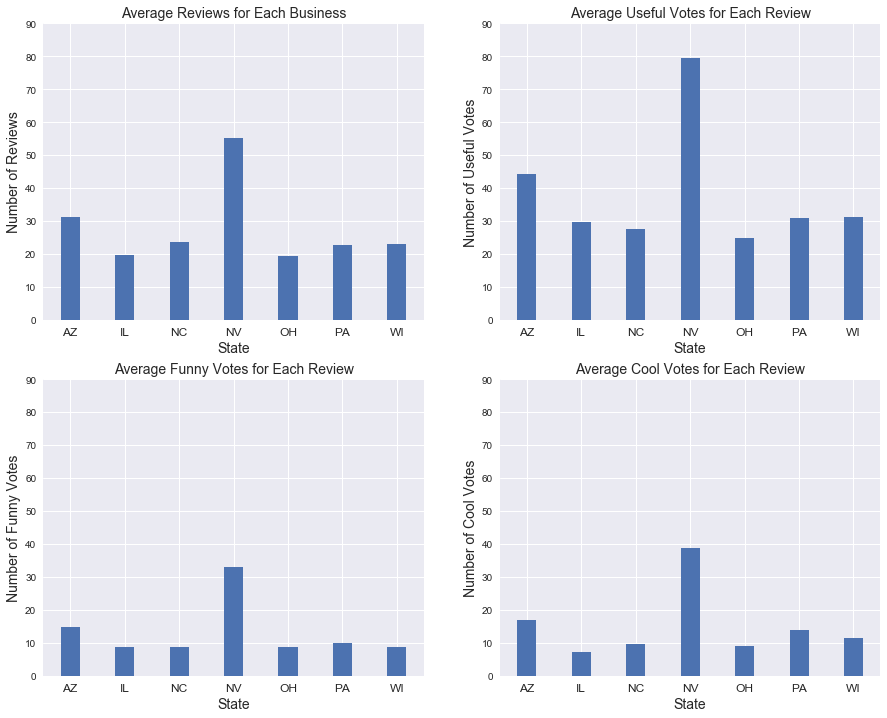

In [12]:
plt.figure(figsize=(15,12))
plt.tight_layout()

plt.subplot(221)
plt_3_1 = plt.bar(stats_1.state,stats_1['review_count']/stats_1['business_count'],width=0.35)
plt.xticks(size=12)
plt.title("Average Reviews for Each Business",size=14)
plt.xlabel("State",size=14)
plt.ylabel("Number of Reviews",size=14)
plt.ylim(ymax=90,ymin=0)

plt.subplot(222)
plt_3_2 = plt.bar(stats_1.state,stats_1['useful']/stats_1['business_count'],width=0.35)
plt.xticks(size=12)
plt.title("Average Useful Votes for Each Review",size=14)
plt.xlabel("State",size=14)
plt.ylabel("Number of Useful Votes",size=14)
plt.ylim(ymax=90,ymin=0)

plt.subplot(223)
plt_3_3 = plt.bar(stats_1.state,stats_1['funny']/stats_1['business_count'],width=0.35)
plt.xticks(size=12)
plt.title("Average Funny Votes for Each Review",size=14)
plt.xlabel("State",size=14)
plt.ylabel("Number of Funny Votes",size=14)
plt.ylim(ymax=90,ymin=0)


plt.subplot(224)
plt_3_4 = plt.bar(stats_1.state,stats_1['cool']/stats_1['business_count'],width=0.35)
plt.xticks(size=12)
plt.title("Average Cool Votes for Each Review",size=14)
plt.xlabel("State",size=14)
plt.ylabel("Number of Cool Votes",size=14)
plt.ylim(ymax=90,ymin=0)
plt.show()

The plot above shows that Nevada state either average reviews for each business, or all kinds of votes for each review, are far higher than other states. 

**Nevada obviously is the most active state for Yelp.**

Next we will do similar statistics for all cities like what we have done for all states

In [13]:
stats_3 = business.groupby(['state','city'])[['review_count','review_votes']].agg('sum')
stats_3['business_count'] = business.groupby(['state','city'])['business_id'].agg('count')
stats_3['avg_stars'] = round(business.groupby(['state','city'])['stars'].agg('mean'),2)
stats_3 = stats_3.reset_index()

stats_4 = business.groupby(['state','city','cat_groups'])[['review_count','review_votes']].agg('sum')
stats_4['business_count'] = business.groupby(['state','city','cat_groups'])['business_id'].agg('count')
stats_4['avg_stars'] = round(business.groupby(['state','city','cat_groups'])['stars'].agg('mean'),2)
stats_4 = stats_4.reset_index()
stats_4 = stats_4.sort_values(['state','city','business_count'],ascending=[True,True,False])

In [14]:
stats_3.head()

,state,city,review_count,review_votes,business_count,avg_stars
0,AZ,Apache Junction,23,78,2,3.50
1,AZ,Avondale,16581,34255,622,3.45
2,AZ,Buckeye,45,63,3,4.83
3,AZ,Carefree,1957,4013,84,3.92
4,AZ,Cave Creek,10087,17254,380,3.99


In [15]:
stats_4.head()

,state,city,cat_groups,review_count,review_votes,business_count,avg_stars
0,AZ,Apache Junction,"Auto,Transportation",23,78,2,3.50
3,AZ,Avondale,Entertainment & Catering,10469,20606,220,3.40
6,AZ,Avondale,Nearby Services,1489,2715,104,3.70
1,AZ,Avondale,"Auto,Transportation",1814,4818,73,3.39
4,AZ,Avondale,"Fitness,Health Care",869,1800,69,3.49


In [16]:
len(business)

127189

### Statistics Mapping
After doing statistics for all states and all cities, we can mapping these statistics.

On the map of states, We will show three icons representing top three business groups in each state. Clicking on any icon will pop up an information window showing general statistics of the state and its top three business groups.

Using the drop down menu, we can choose a state to show a new map with all cities' statistics in the state. We will show 2 to 5 icons representing the top 2 - top 5 business groups in each city. The number of icons depends on how many cities in the state, more cities less icons, vice versa.

At last, we can choose a city in a state to show a map with up to 200 businesses in the descending order by the value of each business' total reviews. The reason choosing the number of reviews because it's a important metric measuring the social activities on each business. Later we will do hypothesis test for the relationship between the number of reviews and the number of review votes.

In [17]:
interact(choose_map_type, MapType=['USA','State'])

interactive(children=(Dropdown(description='MapType', options=('USA', 'State'), value='USA'), Output()), _dom_classes=('widget-interact',))

<function __main__.choose_map_type>

### Hypothesis Test for Linear Relationship
We have mapped statistics on state-level, city-level and business-level. Now we will make plots for the relationship between 'review_count' and 'review_votes'. 

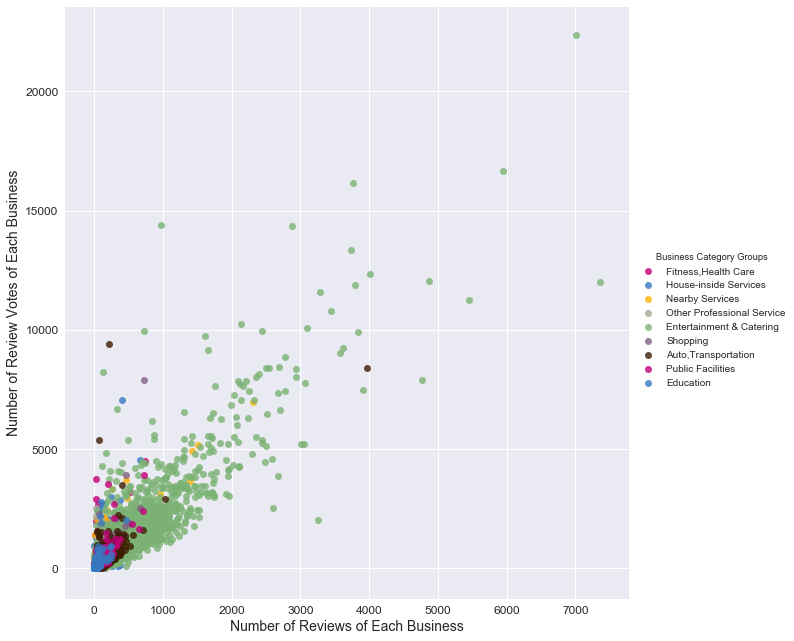

In [17]:
plt_4 = sns.lmplot( x="review_count", y="review_votes", 
           data=business, fit_reg=False, palette=pal,scatter_kws={'alpha':0.8},hue='cat_groups', 
                   legend=True,legend_out=True,size=9)

(plt_4.set_xlabels("Number of Reviews of Each Business",size=14)
        .set_ylabels("Number of Review Votes of Each Business",size=14)
        .set_xticklabels(size=12)
        .set_yticklabels(size=12))
plt_4._legend.set_title("Business Category Groups")
plt.show()

This plot shows there is a positive relationship between 'review_count' and 'review_votes'. We can plot this relationship separated by business category groups. 

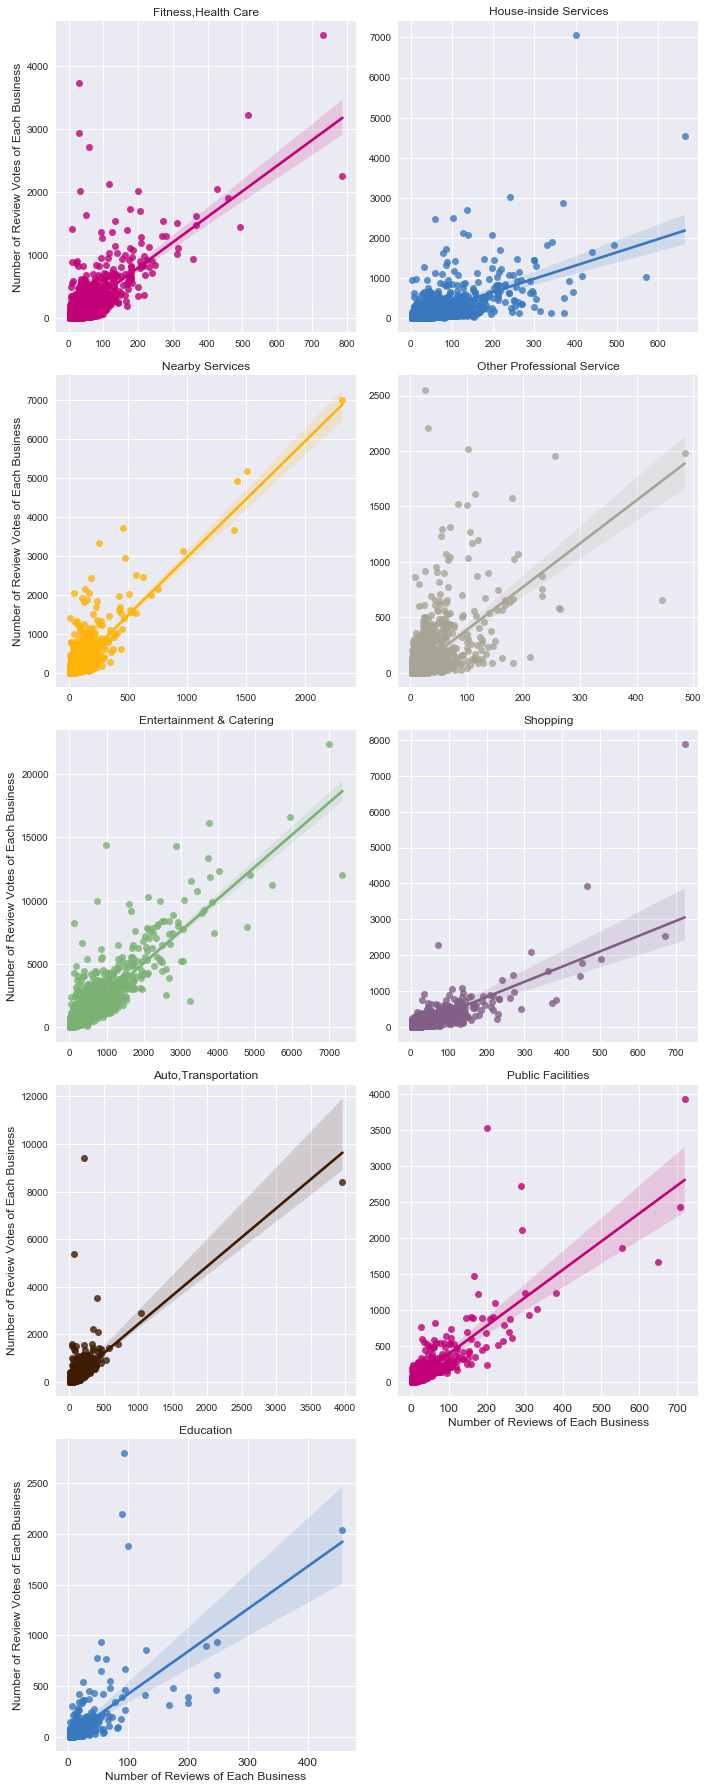

In [18]:
plt_5 = sns.lmplot(x="review_count", y="review_votes",hue="cat_groups",sharex=False, sharey=False,
           col="cat_groups", col_wrap=2,size=5, palette=pal,scatter_kws={'alpha':0.8},truncate=True,data=business);
(plt_5.set_xlabels("Number of Reviews of Each Business",size=12)
     .set_ylabels("Number of Review Votes of Each Business",size=12)
     .set_titles("{col_name}",size=12)
     .set_xticklabels(size=12))

plt.show()

Plot plt_5 shows that 'review_count' and 'review_votes' has a positive relationship in each of the nine business group. 'Entertainment & Catering', 'Shopping' and 'Nearby Services' even have stronger positive relationship.

### Hypothesis Test
#### Null Hypothesis
The number of reivews and the number of review votes are completely uncorrelated.

#### Pearson Correlation Coefficient Statistic and Bootstrap method

In [19]:
def pearson_cc(x,y):
    return np.corrcoef(x,y)[0,1]

def draw_bs_relation(x, y, func,args=None,size=1,corr=False) :
    bs_reps = []
    inds = np.arange(len(x))
    
    for i in range(size):
        if corr :
            bs_inds = np.random.choice(inds,size=len(inds))
            bs_x, bs_y = x[bs_inds], y[bs_inds]
        else :
            bs_x = np.random.choice(x, size=len(x))
            bs_y = np.random.choice(y, size=len(y))
        
        if args:
            bs_reps.append(func(bs_x,bs_y,*args))
        else:
            bs_reps.append(func(bs_x,bs_y))

    return bs_reps

review_count = business['review_count'].values
review_votes = business['review_votes'].values


We will use the Pearson Correlation Coefficient as the statistic to do the hypothesis test. 

At First we will calculate the Pearson Correlation Coefficient with current samples in the business dataframe.

In [20]:
corrcoef_reviews_votes = pearson_cc(review_count,review_votes)
print("Pearson Correlation Coefficient of Observed: ", corrcoef_reviews_votes)

Pearson Correlation Coefficient of Observed:  0.8922885763465185


The Pearson Correlation Coefficient of sample data is near 0.89, this means there may be a strong positive relationship between the two variables.

Then under the null hypothesis, we will use bootstrap method to simulate 10000 times experiments choosing randomly values of 'review_count' and 'review_votes'.

In [21]:
bs_replicates_corrcoef = np.array(draw_bs_relation(review_count,review_votes,pearson_cc,size=10000))

<function matplotlib.pyplot.show>

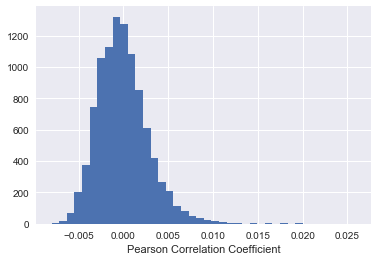

In [22]:
_ = plt.hist(bs_replicates_corrcoef,bins=40)
plt.xlabel('Pearson Correlation Coefficient')
plt.show

Next, we will calculate the probability that the statistic of bootstrap data is at least as extrem as the statistic of observed sample data, which is the p-value.

In [23]:
p = np.sum(bs_replicates_corrcoef >= corrcoef_reviews_votes)/len(bs_replicates_corrcoef)
print("p-value:", p)

p-value: 0.0


The result of p-vlaue is zero,actually it is too small and close to zero. This means the null hypothesis is rejected, and **there is a strong positive relationship between the number of reviews and the number of review votes.**